# Problem statement

https://scholar.google.co.in/scholar_url?url=https://dspace.mit.edu/bitstream/handle/1721.1/43141/247085315-MIT.pdf%3Fsequence%3D2&hl=en&sa=X&ei=3mqcZtL-Op2A6rQPutDjsQU&scisig=AFWwaeaRgp7e--N60Rqptm_OmoMw&oi=scholarr

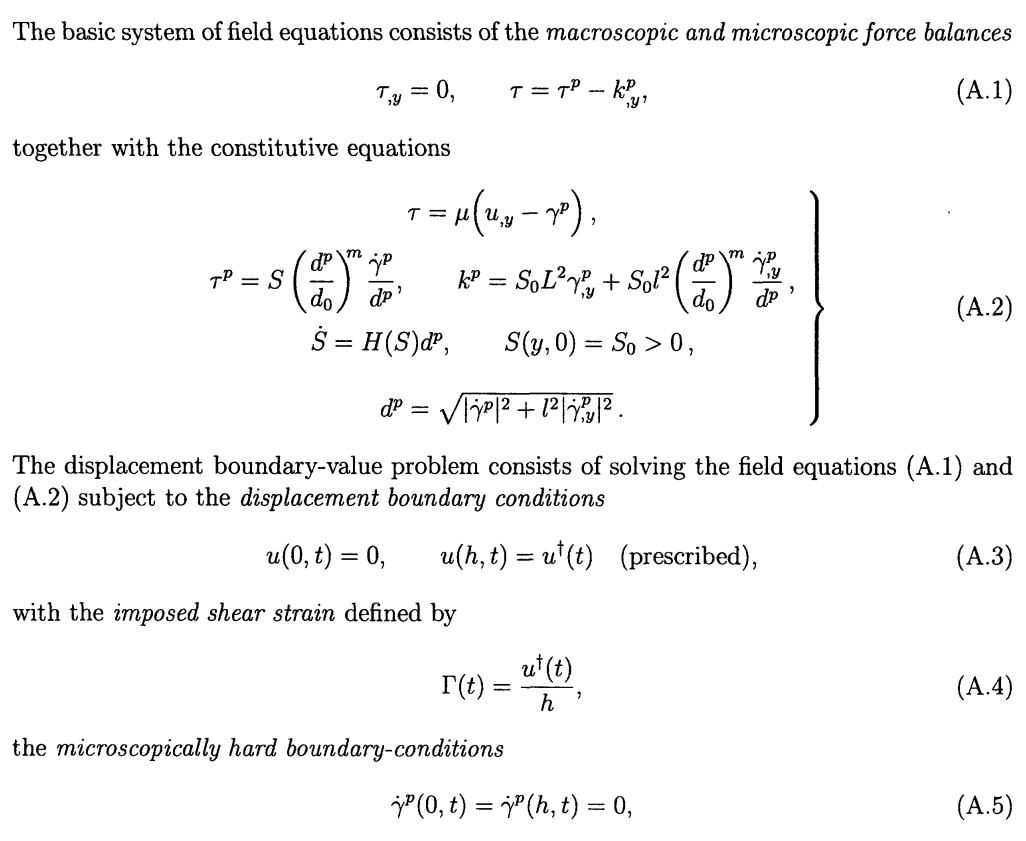

In [100]:
from IPython.display import Image
Image(filename='SGP_1d.png', width = 500)

# imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle
import FINDER_core

Using cuda device for FINDER


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


# Boundary and collocation points

In [3]:
xmin = 0
xmax = 10
tmin = 0
tmax = 0.5
umax = 1.0

In [4]:
length = xmax - xmin
total_time = tmax - tmin

In [5]:
S0 = 100
μ = 100e3
d0 = 0.1
m = 0.02

In [6]:
l_en = length
L = length
T = total_time
Γ = S0 / μ
U = Γ * L

x0 = xmin / L
x1 = xmax / L
t0 = tmin / T
t1 = tmax / T

In [7]:
nx = 32
nt = 32
ts = torch.linspace(t0, t1, nt)
ts = ts[1:]
xs = torch.linspace(x0, x1, nx)
xs = xs[1:-1]
tgrid, xgrid = torch.meshgrid(ts, xs)
X_train = torch.cat((tgrid.flatten().unsqueeze(1), xgrid.flatten().unsqueeze(1)), dim=1)


/home/uttam/miniforge3/envs/torch/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
X_train.shape

torch.Size([930, 2])

# model class

In [9]:
class Model(nn.Module):
    def __init__(self, X_c):
        super(Model, self).__init__()
        self.t = X_c[:,0].clone().detach().reshape(-1,1).requires_grad_(True).to(device)
        self.x = X_c[:,1].clone().detach().reshape(-1,1).requires_grad_(True).to(device)
        self.X_f = torch.cat([self.t, self.x], dim = 1)

        self.create_net()
        self.loss = nn.MSELoss()
        self.ls = 0
        self.start = torch.nn.utils.parameters_to_vector(self.parameters()).to(device)
        self.grads = torch.zeros_like(self.start)
        
    def subnet(self):
        return nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 128), nn.Tanh(),
            # nn.Linear(128, 128), nn.Tanh(),
            # nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 1))
    
    def create_net(self):
        self.u =  self.subnet()
        self.γp = self.subnet()
        
    def net_f (self):
        self.u_m = self.x * (1 - self.x) * self.t * self.u(self.X_f) + self.t * self.x * (umax/U)
        self.γp_m =  self.x * (1 - self.x) * self.t * self.γp(self.X_f)

        du_dx = torch.autograd.grad(self.u_m, self.x, grad_outputs=torch.ones_like(self.u_m), retain_graph=True, create_graph=True)[0]
        d2u_dx2 = torch.autograd.grad(du_dx, self.x, grad_outputs=torch.ones_like(du_dx), retain_graph=True, create_graph=True)[0]
        dγp_dx = torch.autograd.grad(self.γp_m, self.x, grad_outputs=torch.ones_like(self.γp_m), retain_graph=True, create_graph=True)[0]
        γpdot = torch.autograd.grad(self.γp_m, self.t, grad_outputs=torch.ones_like(self.γp_m), retain_graph=True, create_graph=True)[0]
        d2γp_dx2 = torch.autograd.grad(dγp_dx, self.x, grad_outputs=torch.ones_like(dγp_dx), retain_graph=True, create_graph=True)[0]
        dp = torch.abs(γpdot)
        
        macro_loss = self.loss((d2u_dx2 - dγp_dx), torch.zeros_like(d2u_dx2))
        micro_loss = self.loss((du_dx - self.γp_m - ((dp * Γ/T)/d0)**m * torch.sign(γpdot) + (S0/μ) * l_en**2 * d2γp_dx2/L**2), torch.zeros_like(du_dx))
        colloc_loss = macro_loss + micro_loss
        return colloc_loss
    
    def loss_grad(self, param, inputs = None, labels = None, no_grad = False):
        # setting the network parameters
        torch.nn.utils.vector_to_parameters(param, self.parameters())

        # zeroing the gradients
        self.zero_grad()

        if no_grad == False:
            self.ls = self.net_f()
            self.ls.backward()
            self.grads[:] = torch.nn.utils.parameters_to_vector([token.grad for token in self.parameters()])
            return self.ls.detach().item(), self.grads
        else:
            loss_f = self.net_f()
            with torch.no_grad():
                self.ls = loss_f
                return self.ls.detach().item()
        

# model and optimizer

In [10]:
pinn = Model(X_train).to(device)

In [12]:
start = torch.nn.utils.parameters_to_vector(pinn.parameters()).clone().detach()

In [13]:
FINDER = FINDER_core.FINDER(pinn, γ = 1, θ = 0.9, clamps = [0.01, 0.01])

In [14]:
torch.nn.utils.vector_to_parameters(pinn.start, pinn.parameters())

In [15]:
pinn.start.shape

torch.Size([33666])

In [16]:
start.shape

torch.Size([33666])

# train with FINDER

In [17]:
pinn.loss_grad(start.to(device),inputs=None,no_grad=True)

3408.44873046875

In [18]:
every = 100
tic = time.time()
fx = []
for epoch in range(50000):
    pinn.train()
    min_fitness_value = FINDER.step(inputs=None)
    fx.append(min_fitness_value)
    if (epoch) % every == 0:
        print('Epoch [%d] loss: %.10f' %(epoch, min_fitness_value))
    if min_fitness_value < 1e-3:
        break
    if min_fitness_value < 0.1:
        FINDER.clamps = [0.000001, 0.000001]
toc = time.time()
print("finished training in: ", toc - tic, " seconds")

Epoch [0] loss: 3376.8171386719
Epoch [100] loss: 2.2014458179
Epoch [200] loss: 0.1975581944
Epoch [300] loss: 0.0822886974
Epoch [400] loss: 0.0757609606
Epoch [500] loss: 0.0756393373
Epoch [600] loss: 0.0754531622
Epoch [700] loss: 0.0622844025
Epoch [800] loss: 0.0425404310
Epoch [900] loss: 0.0422684029
Epoch [1000] loss: 0.0327313617
Epoch [1100] loss: 0.0283403005
Epoch [1200] loss: 0.0260806493
Epoch [1300] loss: 0.0240462422
Epoch [1400] loss: 0.0227977615
Epoch [1500] loss: 0.0219201706
Epoch [1600] loss: 0.0211789701
Epoch [1700] loss: 0.0201853141
Epoch [1800] loss: 0.0193358865
Epoch [1900] loss: 0.0187472999
Epoch [2000] loss: 0.0181520432
Epoch [2100] loss: 0.0176493395
Epoch [2200] loss: 0.0171655044
Epoch [2300] loss: 0.0167720523
Epoch [2400] loss: 0.0162395500
Epoch [2500] loss: 0.0155067313
Epoch [2600] loss: 0.0149773527
Epoch [2700] loss: 0.0144706722
Epoch [2800] loss: 0.0140044317
Epoch [2900] loss: 0.0136043811
Epoch [3000] loss: 0.0132948086
Epoch [3100] loss

In [29]:
torch.save(fx,'FINDER_energetic_hardening_L_10_case.pt')

# train with Adam

In [20]:
# Create the model and optimizer
model_adam = Model(X_train).to(device)

torch.nn.utils.vector_to_parameters(start, model_adam.parameters())
optimizer_Adam = torch.optim.Adam(model_adam.parameters(), lr=1e-3)
every = 100
# Train the model

fx_adam = []
tic = time.time()
for epoch in range(50000):
    model_adam.train()
    
    loss = model_adam.net_f()#model_adam.loss_grad(torch.nn.utils.parameters_to_vector(model_adam.parameters()), inputs=None)[0]
    model_adam.zero_grad()
    loss.backward()
    optimizer_Adam.step()
    fx_adam.append(loss.item())
    
    if (epoch) % every == 0:
        print('Epoch [%d] loss: %.8f' % (epoch, loss))
    if loss < 1e-3:
        break

toc = time.time()
print("Finished training in: ", toc - tic, " seconds")

Epoch [0] loss: 3408.44873047
Epoch [100] loss: 3278.10278320
Epoch [200] loss: 3200.02124023
Epoch [300] loss: 3125.55102539
Epoch [400] loss: 3053.21215820
Epoch [500] loss: 2982.49731445
Epoch [600] loss: 2913.14575195
Epoch [700] loss: 2845.15820312
Epoch [800] loss: 2778.19506836
Epoch [900] loss: 2714.05737305
Epoch [1000] loss: 2648.29174805
Epoch [1100] loss: 2585.09204102
Epoch [1200] loss: 2522.72021484
Epoch [1300] loss: 2462.42675781
Epoch [1400] loss: 2402.02661133
Epoch [1500] loss: 2342.63183594
Epoch [1600] loss: 2284.20629883
Epoch [1700] loss: 2232.08789062
Epoch [1800] loss: 2171.32421875
Epoch [1900] loss: 2115.17016602
Epoch [2000] loss: 2070.26000977
Epoch [2100] loss: 2008.89831543
Epoch [2200] loss: 1956.01184082
Epoch [2300] loss: 1904.05981445
Epoch [2400] loss: 1853.02172852
Epoch [2500] loss: 1802.71875000
Epoch [2600] loss: 1753.03515625
Epoch [2700] loss: 1706.32409668
Epoch [2800] loss: 1657.10705566
Epoch [2900] loss: 1610.06933594
Epoch [3000] loss: 156

In [28]:
torch.save(fx_adam,'Adam_energetic_hardening_L_10_case.pt')

# plotting

In [21]:
fx.insert(0,fx_adam[0])

In [25]:
fx_adam[-1]

0.0038017150945961475

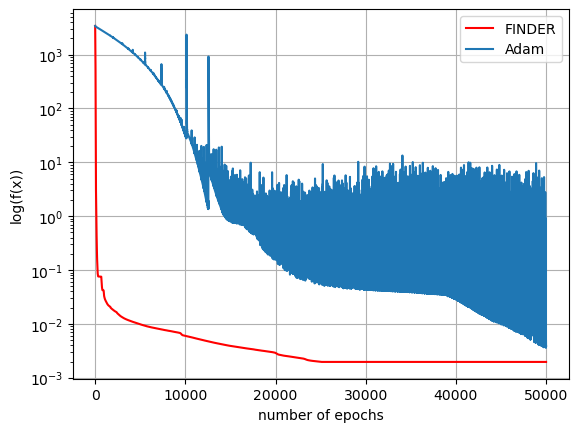

In [23]:
plt.plot(fx,'r',label='FINDER')
plt.plot(fx_adam, label='Adam')
plt.grid()
plt.yscale('log')
plt.xlabel('number of epochs')
plt.ylabel('log(f(x))')
plt.legend()
plt.show()

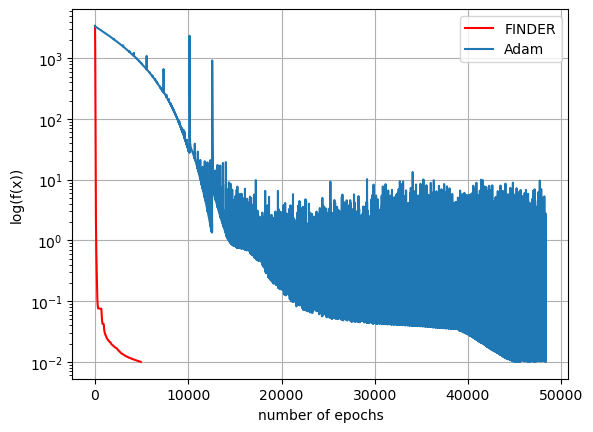

In [33]:
plt.plot([fx[i] for i in range(len(fx)) if fx[i] >= 1e-2], 'r', label='FINDER')
plt.plot([fx_adam[i] for i in range(len(fx_adam)) if fx_adam[i] >= 1e-2], label='Adam')
plt.grid()
plt.yscale('log')
plt.xlabel('number of epochs')
plt.ylabel('log(f(x))')
plt.legend()
plt.show()

# testing

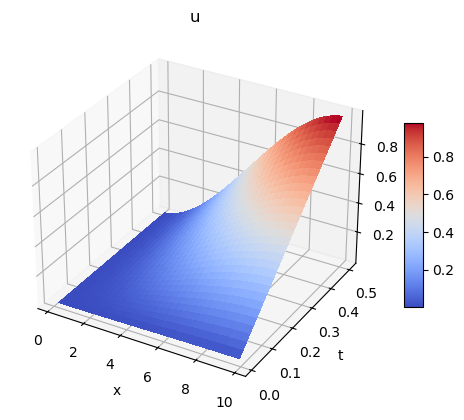

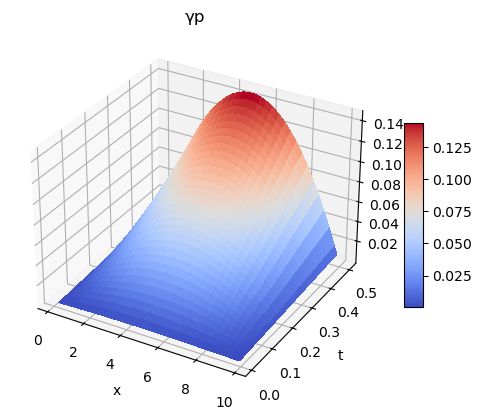

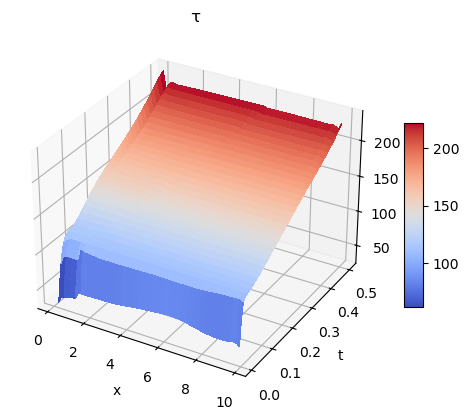

In [87]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

ngrid = 64
ts = torch.linspace(t0, t1, ngrid)
xs = torch.linspace(x0, x1, ngrid)
ts = ts[1:]
xs = xs[1:-1]
tgrid, xgrid = torch.meshgrid(ts, xs)
tgrid1 = tgrid.flatten().view(-1,1).to(device)
xgrid1 = xgrid.flatten().view(-1,1).to(device)
xgrid1.requires_grad_(True)
X = torch.cat([tgrid1, xgrid1], dim=1).to(device)

u = tgrid1 * xgrid1 * (1-xgrid1) * pinn.u(X) + tgrid1 * xgrid1 * umax/U
γp = tgrid1 * xgrid1 * (1-xgrid1) * pinn.γp(X)
u *= U
γp *= Γ
du_dx = torch.autograd.grad(u, xgrid1, grad_outputs=torch.ones_like(u),retain_graph=True)[0] /L
τ = μ * (du_dx - γp)

u = u.detach().cpu().numpy()
γp = γp.detach().cpu().numpy()
τ = τ.detach().cpu().numpy()

names = ['u', 'γp','τ']

for name,value in zip(names,[u, γp, τ]):
    value = value.reshape(xgrid.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(xgrid * L, tgrid * T, value, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    plt.title(name)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()

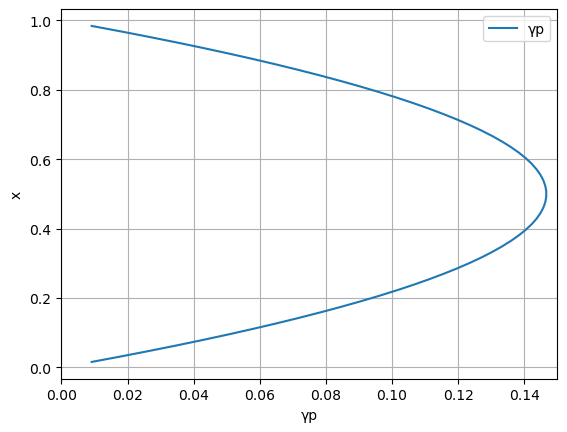

In [90]:
γp_grid = γp.reshape(xgrid.shape)
plt.plot(γp_grid[-1, :],xgrid[-1,:], label = 'γp')
plt.xlim(left=0, right=.15)
plt.grid()
plt.legend()
plt.xlabel('γp')
plt.ylabel('x')
plt.show()

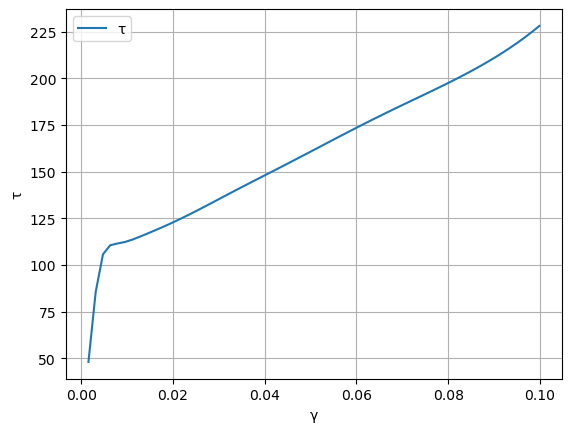

In [97]:
γ_grid = u.reshape(xgrid.shape) / L
τ_grid = τ.reshape(xgrid.shape)
plt.plot(γ_grid[:, -1], τ_grid[:, -1], label = 'τ')
plt.grid()
plt.legend()
plt.xlabel('γ')
plt.ylabel('τ')
plt.show()